<style>
/* Reveal container full viewport */
.reveal {
  width: 95vw !important; /* 95% of view width */
  height: 50vw !important;   /* about 16:9 aspect ratio height (width × 9/16) */
  max-width: 95vw !important;
  max-height: 50vw !important;
  margin: auto;
  font-size: 110%; /* global font size */
}

/* Slides filling container */
.reveal .slides {
  width: 100% !important;
  height: 100% !important;
  max-width: 100% !important;
  max-height: 100% !important;
  margin: auto;
  overflow-wrap: break-word;
}

/* Prevent content from overflowing horizontally */
.reveal section {
  overflow-x: auto;
  word-wrap: break-word;
  box-sizing: border-box;
  padding: 1em;
}

/* Tables scroll horizontally if too wide */
.reveal section table {
  display: block;
  overflow-x: auto;
  white-space: nowrap;
  max-width: 100%;
  margin: 0 auto;
  font-size: 90%;
  border-collapse: collapse;
}

/* Smaller font and compact padding inside table cells */
.reveal section table td,
.reveal section table th {
  font-size: 90%;
  padding: 0.3em 0.5em;
  white-space: nowrap;
}
</style>

# Second Hands-On Session
--- 
Tracking many particles - Twiss parameters

---

## 🐍 Python corner

We'll be using:
- `numpy` as `np`
- `matplotlib.pyplot` as `plt`
- functions `D`, `Q`, `transportParticles`, `getEquivalentElement` and `transportSigmas`

In [1]:
from tracking_library import *

numpy is installed, version: 2.3.1
scipy is installed, version: 1.15.3
matplotlib is installed, version: 3.10.0
-> Setup is OK! Have fun!


## 📝 Exercise 2.1 (guided): Generating an ensemble of particles <a id="exercise-2.1-guided"></a>

Define an ensemble of 1000 particles with arbitrary first order (e.g. $<x_0> = 0.2$ mm, $<x'_0> = 1$ mrad) and second order (e.g. $\sigma_{x_0} = 1.5$ mm and $\sigma_{x'_0} = 0.5$ mrad) momenta.
Verify that the angular divergence of the beam is the one set: 

- What do you observe?
- What happens if you increase or decrease the number of particles?

> 👀 **HINT**: Remember that you can create a Normal distributed 2xN 2D array of numbers as `np.random.randn(2, N)`. One can then "stretch" and "offset" (and eventually "rotate", but this is not requested here) this distribution to obtain any desired 2D normal distribution in phase space.

In [6]:
# simple solution
N_particles = 100
beam = np.array([ np.random.randn(N_particles), 
                  np.random.randn(N_particles) ])
# or equivalently:
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
# add a scaling (sigx*) and an offset (+x0) to the x (0) coordinate:
beam[0, :] = sigx * beam[0, :] + x0
# add a scaling (sigxp*) and an offset (+xp0) to the x' (1) coordinate:
beam[1, :] = sigxp * beam[1, :] + xp0

# compute the means and std of the particle coordinates
means = np.mean(beam, 1)
stds  = np.std(beam, 1)

# print the actual means and stds over all particle coordinates
print(f"Beam mean  x [mm]: {means[0]}")
print(f"Beam mean  x' [mrad]: {means[1]}")
print(f"Beam rms size [mm]: {stds[0]}")
print(f"Beam rms divergence [mrad]: {stds[1]}")

Beam mean  x [mm]: 0.19647717016685334
Beam mean  x' [mrad]: 1.0219623476983524
Beam rms size [mm]: 1.2732556772172419
Beam rms divergence [mrad]: 0.4630067064703156


❓**QUESTION: Why didn't we find back the input parameters?**

## 📝 Exercise 2.2: Tracking an ensemble of particles in a drift <a id="exercise-2.2"></a>

1. Transport the beam distribution of [Exercise 2.1](#exercise-2.1-guided) in a drift of length 1 m. Visualise the initial and final distribution. **What do you observe?**

   > 👀 **HINT 1**: the output of `transportParticles` contains the coordinates of all particles at all locations. To obtain all particle coordinates at the end of the beamline, you can simply do:
   >
   > ```
   > tracked = transportParticles(initial_coordinates, beamline)
   > final_coordinates = tracked['coords'][-1] #where "-1" refers to the last element of the beamline
   > ```

   > 👀 **HINT 2**: One can use `plt.plot` or `plt.scatter` to plot the 2D distribution, e.g.:
   > ```
   > plt.scatter(x, xp, marker='.')
   > ```

2. (Optional) Test of linearity. Scale the input vector by 17 times the month of your birthday (e.g. 85 if you are born in May) and verify that the output vector from the matrix multiplication has changed by the same factor.
    
    > 👀 **HINT**: Be careful with machine precision!


### Solution for 1.

In [15]:
# Generate particle coordinates
n_part = 10000
beam = np.random.randn(2, n_part)
x0 = 0
xp0 = 1
sigx = 1
sigxp = 0.5
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0

In [16]:
beam

array([[ 0.14168001, -0.02219947,  0.51295008, ...,  1.45344571,
         0.94585814, -1.02552696],
       [ 1.77994966,  0.81118193,  1.71533927, ...,  0.51986571,
         0.47293896,  0.73535149]], shape=(2, 10000))

In [20]:
# Make beamline
beamline = D(3)

# Trasport particles
tracked = transportParticles(beam, beamline)

In [21]:
tracked

{'x': array([[ 0.14168001, -0.02219947,  0.51295008, ...,  1.45344571,
          0.94585814, -1.02552696],
        [ 5.481529  ,  2.41134631,  5.65896788, ...,  3.01304283,
          2.36467501,  1.18052752]], shape=(2, 10000)),
 'xp': array([[1.77994966, 0.81118193, 1.71533927, ..., 0.51986571, 0.47293896,
         0.73535149],
        [1.77994966, 0.81118193, 1.71533927, ..., 0.51986571, 0.47293896,
         0.73535149]], shape=(2, 10000)),
 's': array([0, 3]),
 'coords': array([[[ 0.14168001, -0.02219947,  0.51295008, ...,  1.45344571,
           0.94585814, -1.02552696],
         [ 1.77994966,  0.81118193,  1.71533927, ...,  0.51986571,
           0.47293896,  0.73535149]],
 
        [[ 5.481529  ,  2.41134631,  5.65896788, ...,  3.01304283,
           2.36467501,  1.18052752],
         [ 1.77994966,  0.81118193,  1.71533927, ...,  0.51986571,
           0.47293896,  0.73535149]]], shape=(2, 2, 10000))}

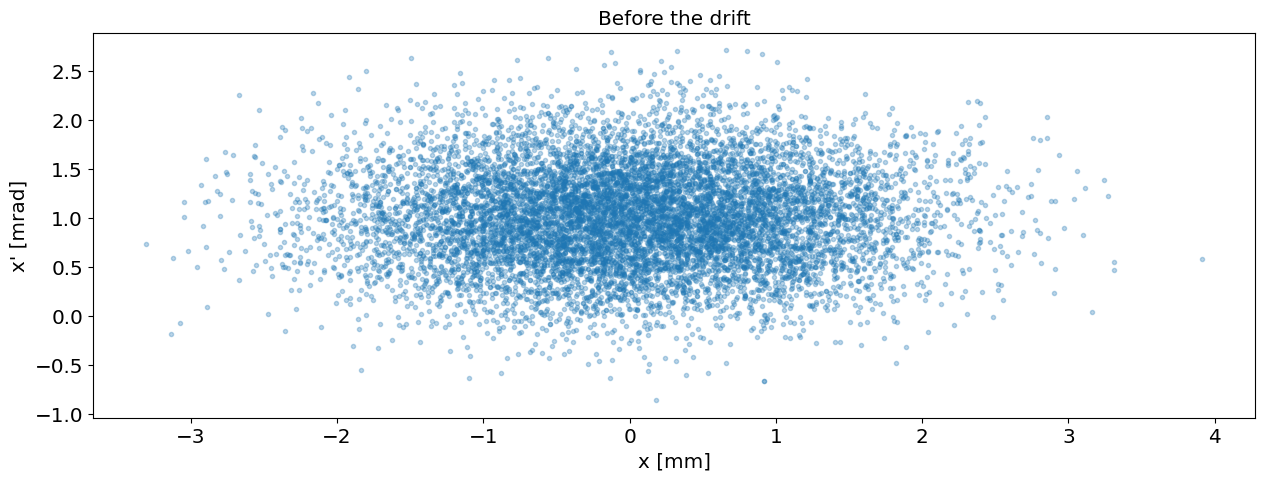

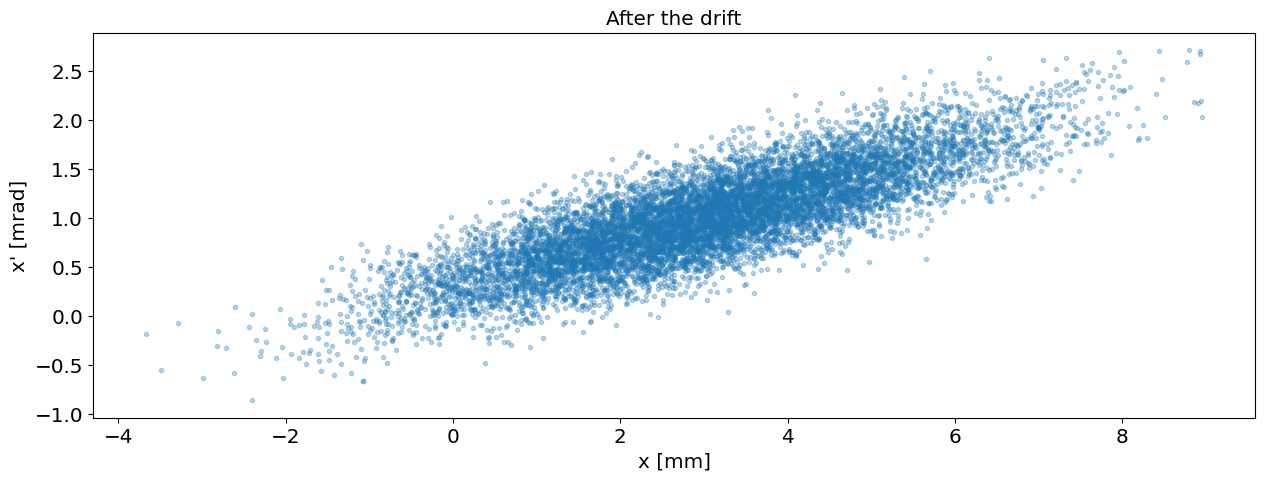

In [22]:
beam_after_drift = tracked["coords"][-1]  # where "-1" refers to the last element of the beamline

# Before the drift
plt.figure()
plt.xlabel("x [mm]")
plt.ylabel("x' [mrad]")
plt.title("Before the drift")
plt.scatter(beam[0, :], beam[1, :], marker='.', alpha=0.3)

# After the drift
plt.figure()
plt.xlabel("x [mm]")
plt.ylabel("x' [mrad]")
plt.title("After the drift")
plt.scatter(beam_after_drift[0, :], beam_after_drift[1, :], marker='.', alpha=0.3)

### Solution for 2. 

In [23]:
month_birthday = 3
v1 = D(1)[0]["matrix"] @ (17 * month_birthday * beam)
v2 = 17 * month_birthday * D(1)[0]["matrix"] @ (beam)

# this might return False due to machine precision rounding - See **Computational tools** course!:
print(np.array_equal(v1, v2))
# let's compare at the level of 10 times epsilon, times the scaling factor used for the test
print(np.max(np.abs(v1 - v2)) < 10 * 17 * month_birthday * np.finfo(v1.dtype).eps)

False
True


## 📝 Exercise 2.3: Tracking an ensemble of particles along a beamline (mean position & beam size) <a id="exercise-2.3"></a>

Build a beamline made of several drift and quadrupoles as desired (e.g. `D(0.5)+Q(1)+D(2)+Q(-1)+D(1)+Q(2)+....`).

Build a beam made of several particles (e.g. 1000) again with arbitrary first order (e.g. $<x_0> = 0.2$ mm, $<x'_0> = 1$ mrad) and second order (e.g. $\sigma_{x_0} = 1.5$ mm and $\sigma_{x'_0} = 0.5$ mrad) momenta, as done in previous [Exercise 2.2](#exercise-2.2).

1. Plot the individual particle trajectories along the beamline

2. Compute and plot the average beam position, the beam size ($\sigma_x$) and divergence ($\sigma_{x'}$) along the beam line.

> 👀 **HINT 1 (Python)**: Remember that in the output of our `transportParticles` function the key `'x'` contains a 2D array with N rows (the index of the position along the beam line) and M columns (the index of a given particle). 
You can compute the standard deviation of **each row** of a NxM 2D array as `np.std(N_times_M_array,1)`. 

> 👀 **HINT 2 (Python)**: After having plotted $x$ trajectory on a matplotlib plot, one can create a **second vertical axis** that shares the same horizontal axis with `plt.twinx()`. This can be convenient to see, for example, both $\sigma_x$ and $\sigma_{x'}$ on the same plot.


In [34]:
# prepare the beamline
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + +10 * D(1.5 / 10))

In [35]:
# prepare the beam
N_particles = 1000
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0

In [36]:
# Transport the particles
transported_particles = transportParticles(beam, beamline)

In [47]:
# Compute means and stds
mean_trajectory = np.mean(transported_particles["x"], 1)
beam_size_evolution = np.std(transported_particles["x"], 1) # "1-sigma"
beam_divergence_evolution = np.std(transported_particles["xp"], 1)

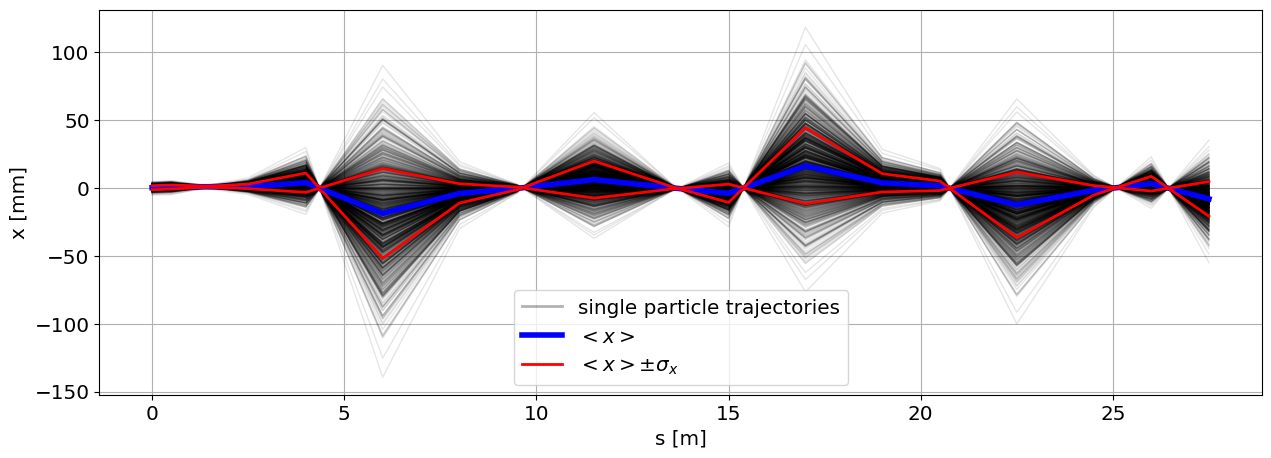

In [46]:
# Plotting
plt.plot(transported_particles["s"], transported_particles["x"], ls="-", color='black', lw=1, alpha=0.1) # individual particle trajectories
plt.plot([],[], ls="-", color='black', lw=2, alpha=0.3, label='single particle trajectories') # dummy plot, for label

plt.plot(transported_particles["s"], mean_trajectory, "-", color='blue', lw=4, label=r'$<x>$') # plotting the mean in blue

plt.plot(transported_particles["s"], mean_trajectory + beam_size_evolution, "-", color='red', lw=2, label=r'$<x> \pm \sigma_x$')
plt.plot(transported_particles["s"], mean_trajectory - beam_size_evolution, "-", color='red', lw=2)

plt.grid(True)
plt.ylabel("x [mm]")
plt.xlabel("s [m]")
plt.legend()

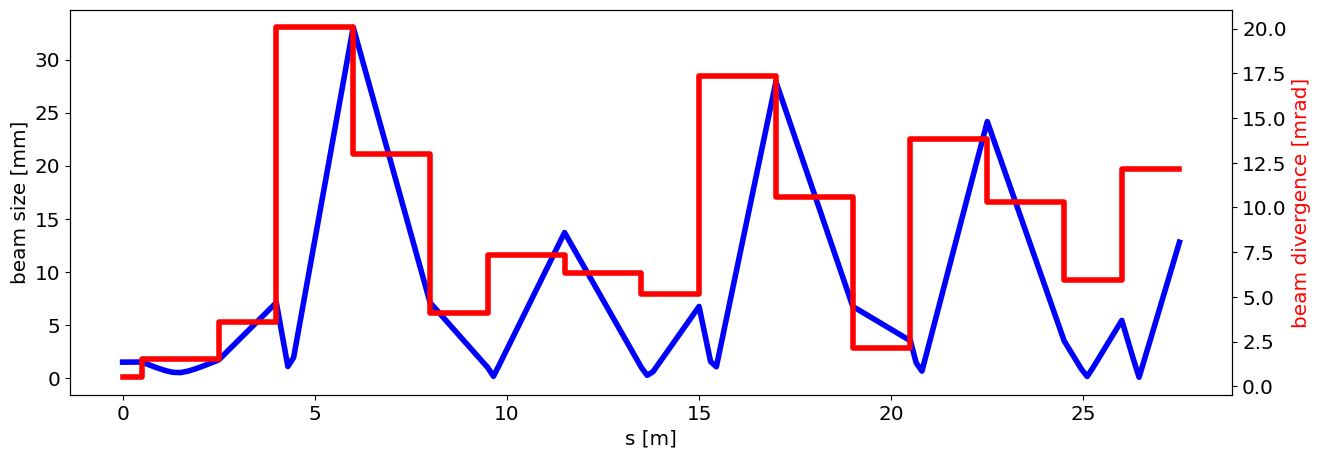

In [55]:
plt.xlabel("s [m]")
plt.ylabel("beam size [mm]")
plt.plot(transported_particles["s"], beam_size_evolution, '-', color='blue', lw=4)

plt2 = plt.twinx()
plt2.set_ylabel('beam divergence [mrad]', color='red')
plt2.plot(transported_particles["s"], beam_divergence_evolution, '-', color='red', lw=4)

## ⚛️ Physics focus: Sigma matrices

One can easily demonstrate (see [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/)) that the same matrix ($M$) used for tracking the coordinates ($(x_i, x'_i)$) of each single particle ($i$) from an initial point ($X_0$) to a final point ($X_s$) in a beamline:

\begin{equation}
X_s =  M\, X_0
\end{equation}

can also be used to track the **average trajectory** ($\langle X \rangle$) as well as the **covariance or sigma matrix** of the given particle coordinates distribution:

\begin{equation}
\langle X_s \rangle = 
\left[
\begin{array}{c}
\langle x_i \rangle\\
\langle x'_i \rangle
\end{array}
\right]_s 
= M\, \langle X_0 \rangle
\end{equation}

\begin{equation}
\Sigma_s = \left[
\begin{array}{c}
\sigma_{xx}\quad \sigma_{xx'}\\
\sigma_{x'x}\quad \sigma_{x'x'}
\end{array}
\right]_s
= M\, \Sigma_0\, M^T\, .
\end{equation}

We can therefore "track" the **covariance** of a beam simply starting from its initial covariance matrix in phase space !
This "tracking" of an initial **covariance** matrix along a given beamline is provided by the function `transportSigmas()` from our toolbox:

In [56]:
from tracking_library import transportSigmas

# let's see if there is some help information:
help(transportSigmas)

Help on function transportSigmas in module tracking_library:

transportSigmas(sigma_0, beamline)
    Transport a sigma matrix through a beamline.

    Parameters
    ----------
    sigma_0 : ndarray
        Initial 2x2 sigma matrix.
    beamline : list of dict
        Sequence of beamline elements.

    Returns
    -------
    result : dict
        Dictionary with keys:
            'sigma11', 'sigma12', 'sigma21', 'sigma22' : [N] sigma matrix elements,
            's'                                        : [N] longitudinal positions,
            'sigmas'                                   : [N x 2 x 2] full sigma matrices.

    Disclaimer
    -------
    If beamline is made of 5 elements, the output will have 5+1 "elements" as it will also return include the initial particle coordinates.



## 📝 Exercise 2.4: Tracking only the average beam position

Show that **the average position of a beam along a beam line** (e.g. the beamline and beam you defined in [Exercise 2.3](#exercise-2.3)) is the same as **the trajectory of single particle that starts in the center of the initial particle distribution**.

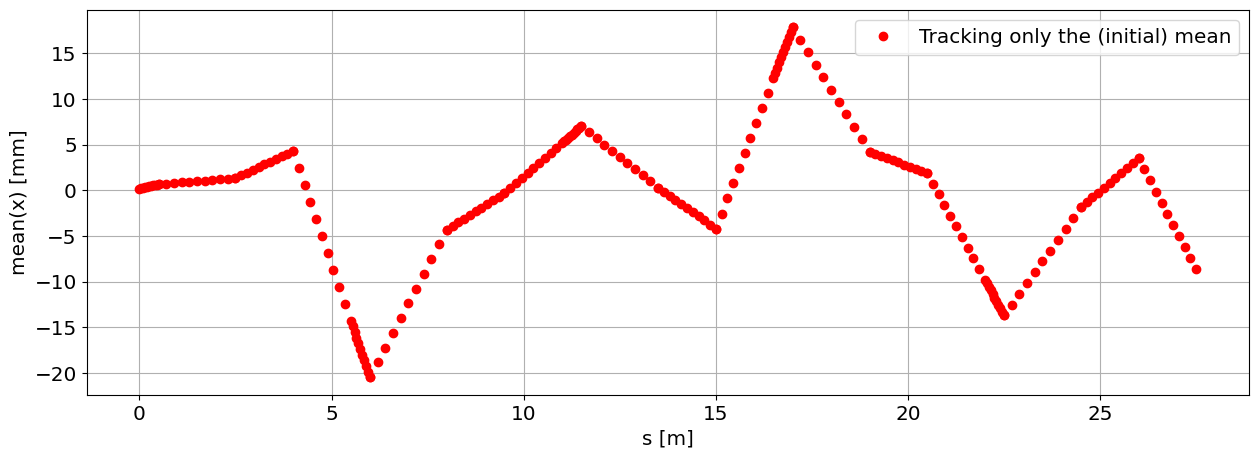

In [57]:
# As exercise 2.3
# prepare the beamline
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + +10 * D(1.5 / 10))
# prepare the beam
N_particles = 1000
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0

# single particle that starts in the center of the initial particle distribution
single_particle = np.array([ [np.mean(beam[0, :])],     # average position
                             [np.mean(beam[1, :])] ])  # average divergence

# transport only the average position
transported_mean = transportParticles(single_particle, beamline)

plt.plot(transported_mean["s"], transported_mean["x"], "or", lw=3, label="Tracking only the (initial) mean")
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("mean(x) [mm]")
plt.legend()

## 📝 Excercise 2.5: Tracking only the beam size

For the same system as before, track only the sigma matrix and compare with the rms beam size computed from tracking all particles (Exercise 2.3).

> 🔹 **NOTE**: Is this valid for any number of initially tracked particles? How does the result change if one uses the **input** covariance matrix used to generate the particle distribution rather then the **actual** covariance matrix of the generated distribution?

> 👀 **HINT 1**: Remember that the element $\sigma_{xx}$ of the covariance matrix is linked to the rms beam size ($\sigma_x$) as $\sigma_x = \sqrt{\sigma_{xx}}$.

> 👀 **HINT 2**: The covariance matrix of a 2xN array can be computed using `numpy` as `np.cov(2_times_N_array, bias=True)`.

In [70]:
# Exactly as exercise 2.3

# prepare the beamline
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + +10 * D(1.5 / 10))

# prepare the beam
N_particles = 50
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0

In [71]:
# Prepare the sigma matrix

# "by-hand", based on our inputs assuming no correlation between x and xp (i.e. zero antidiagonal terms)
sigma_0 = np.array([ [sigx**2,        0], 
                     [0,       sigxp**2] ])

# alternative: using np.cov which takes into account the small antidiagonal terms
sigma_real = np.cov(beam, bias=True)

In [72]:
# transport the beam sigmas

transported_sigmas = transportSigmas(sigma_0, beamline) # assuming zero correlation
transported_real_sigmas = transportSigmas(sigma_real, beamline) # taking into account the small correlation

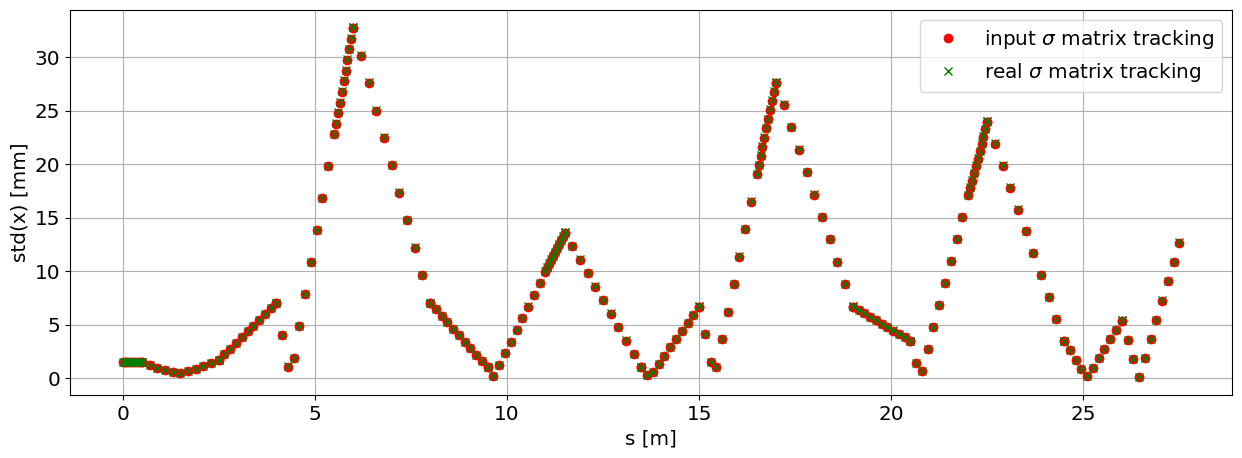

In [73]:
# plot all estimation of beam size:
plt.plot(transported_sigmas["s"], np.sqrt(transported_sigmas["sigma11"]), "or", lw=3, label=r"input $\sigma$ matrix tracking")
plt.plot(transported_real_sigmas["s"], np.sqrt(transported_real_sigmas["sigma11"]), "xg", lw=3, label=r"real $\sigma$ matrix tracking")
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("std(x) [mm]")
plt.legend()

> 🔹 **NOTE**: It is important to observe that the result of from the particle tracking and the sigma matrix tracking are equivalent.
The small deviation is due to the statistical noise of the ensemble (it can be reduced by increasing the number of particles).
This deviation is zero (or numerical) if one tracks the actual covariance matrix of the ensemble of the generated particles. (Note that the `bias=True` option to numpy `cov` function is necessary to force the simple (bias) computation of the covariance)
> 
> Clearly, the sigma matrix tracking is computationally cheaper than the particle tracking (if n_part>>1).

## ⚛️ Physics focus: Introduction of Twiss values and emittance

Recall that:

\begin{equation}
\Sigma_{s} = M\, \Sigma_{0}\, M^T\, .
\end{equation}

where $M$ is a real **symplectic** transformation, and its determinant is $\det(M) = +1$. Therefore:

\begin{equation}
\det(\Sigma_s) = \det( M\, \Sigma_0\, M^T ) = \det(M) \det(\Sigma_0) \det(M^T) = \det(\Sigma_0)
\end{equation}

the determinant of the sigma/covariance matrix is **preserved** along a beamline. The sigma/covariance matrix of any particle distribution can be parameterized as:

\begin{equation}
\Sigma = 
    \left[
    \begin{array}{cc}
    \sigma_{xx}  & \sigma_{xx'}\\
    \sigma_{x'x} & \sigma_{x'x'}
    \end{array}
    \right] =
    \epsilon
    \left[ 
    \begin{array}{cc}
        \beta   & -\alpha\\
        -\alpha & \gamma
    \end{array}
    \right] 
\end{equation}

where $\beta$, $\alpha$, $\gamma$ and $\epsilon$ are parameters such that $\epsilon = \sqrt{\det(\Sigma)}$ (the beam **statistical emittance**) and $\beta \gamma - \alpha^2 = 1$. The *Twiss* parmeters $\beta, \gamma, \alpha$ define the **normalised** shape/orientation of the beam distribution in phase-space!

**This seems to be an arbitrary choice!** but it will acquire more special meaning later.

## 📝 Exercise 2.6: Equivalent matrix symplecticity
Verify that the equivalent transport matrix of any beamline, e.g. the one you used in [Exercise 2.3](#exercise-2.3), has determinant equal to 1 (within machine precision).

> 👀 **HINT (Python)**: you can use `np.linalg.det(matrix)` to compute the determinant of a matrix `matrix`

In [75]:
# lattice
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + +10 * D(1.5 / 10))

# compute equivalent matrix of the whole beamline
OTM = getEquivalentElement(beamline)
print(f'The determinant of the FODO OTM is {np.linalg.det(OTM[0]["matrix"])}.')

The determinant of the FODO OTM is 0.9999999999999054.


## 📝 Exercise 2.7: Evolution of Twiss parameters in a beamline

Consider again a beamline, e.g. the one you used in [Exercise 2.3](#exercise-2.3), and create a valid sigma matrix with:
- $\beta$ = 3 [m]
- $\gamma$ = 0.5 [1/m]
- $\epsilon$ = 5 [$\mu$ m]

Then, propagate the $\sigma$ matrix through the beam line and verify that the emittance $\epsilon$ of the sigma matrix after every element is indeed constant and equal to its initial value.

**Optional:** compute and plot the **beta** (function) all along the beamline, i.e. $\sigma_{11}/\epsilon$

> 👀 **HINT (Python)**: in the output of our `transportSigmas()` function we keep all sigma matrixes. The determinant of all matrices can be computed in one go as `np.linalg.det(transported_sigmas['sigmas'])`.

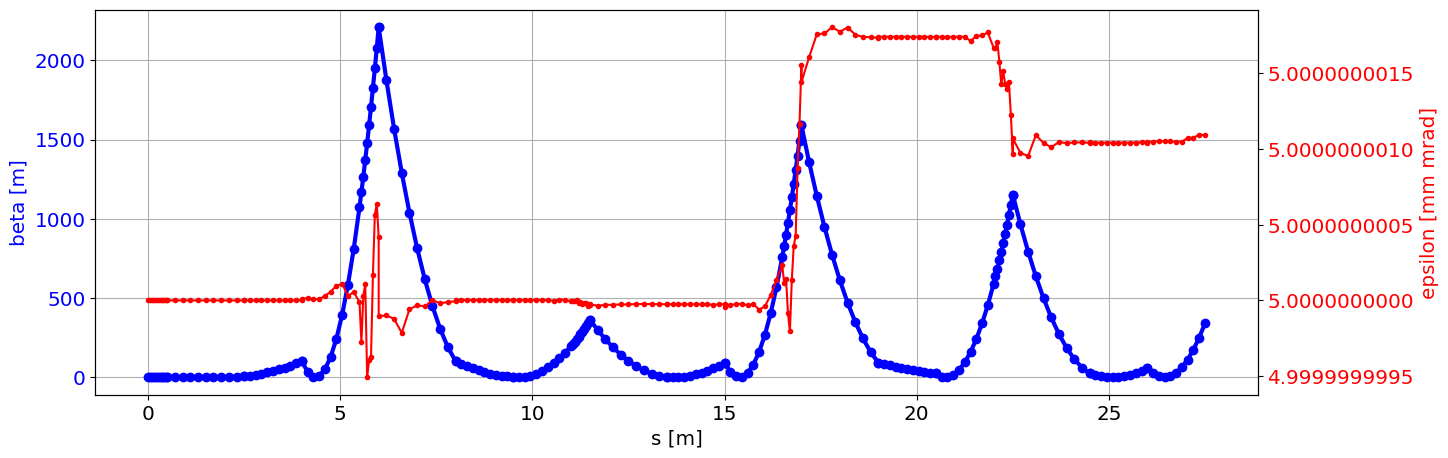

In [74]:
# lattice
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + 10 * D(1.5 / 10))

# let's create a simple sigma matrix
beta0 = 3
gamma0 = 0.5
epsilon0 = 5
# alfa must be:
alfa0 = np.sqrt(beta0 * gamma0 - 1)
sigma_0 = epsilon0 * np.array([[beta0, -alfa0], [-alfa0, gamma0]])

# transport the sigma matrix:
transported_sigmas = transportSigmas(sigma_0, beamline)

# compute the emittance as sqrt of the determinant of all sigma matrices along
# the beamline
emittance = np.sqrt(np.linalg.det(transported_sigmas["sigmas"]))
# the beta function can be extracted as well from the 'sigma11' element,
# divided by the emittance
beta = transported_sigmas["sigma11"] / emittance

# make a simple plot
plt.plot(transported_sigmas["s"], beta, "o-b", lw=3)
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("beta [m]", color="b")
plt.tick_params(axis="y", labelcolor="b")

ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.ylabel("epsilon [mm mrad]", color="r")
plt.tick_params(axis="y", labelcolor="r")
plt.plot(transported_sigmas["s"], emittance, ".-r")
plt.ticklabel_format(useOffset=False)

## Well done !!

Now you understand how to transport an ensamble of particles or its **covariance** matrix along a beamline... But how to design a "nice" beamline?

=> **Continue your learning with the following [notebook](./03_Periodic_Systems.ipynb)**...
